In [1]:
import os
if not os.path.exists('./outputs'):
    os.mkdir('./outputs')   

## For ceemdan

In [73]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 提取RESULT文件里的模型名和预测数据
def get_result(file_name,first_):
    model_names,  names = ['auto', 'cross', 'non', 'DL', 'trans', 'pyra', 'times', 'inf', 'light', 'FED'], []
    preds = []
    for num_of_model in range(10):
        files = os.listdir(f'./RESULTS/{file_name}/results') 
        curIndex, count, name = -1, 0, files[num_of_model]
        preds.append(f'./RESULTS/{file_name}/results/{name}/pred.npy')
        while count < first_+1:
            lastIndex = curIndex
            curIndex += name.index('_') + 1
            count += 1
            name = files[num_of_model][curIndex+1:]
        if (model_name := files[num_of_model][lastIndex+1:curIndex]) in model_names:
            names.append(model_name)
        else:
            print("WRONG:",model_name)
    return names, preds

# 为每个模型建立预测数据的data frame
def create_pred_df(model, high_model_names, low_model_names, trend_model_names, high_preds, low_preds, trend_preds):
    high_model_index = high_model_names.index(model)
    low_model_index = low_model_names.index(model)
    trend_model_index = trend_model_names.index(model)
    high_pred = np.load(high_preds[high_model_index])[:,:,-1]
    low_pred = np.load(low_preds[low_model_index])[:,:,-1]
    trend_pred = np.load(trend_preds[trend_model_index])[:,:,-1]
    preds = {}
    preds[model+'_high'] = high_pred.squeeze()
    preds[model+'_low'] = low_pred.squeeze()
    preds[model+'_trend'] = trend_pred.squeeze()
    preds = pd.DataFrame(preds)
    preds[model+'_pred_return'] = preds[model+'_high'] + preds[model+'_low'] + preds[model+'_trend']
    return preds

high_model_names, high_preds  = get_result('return_IMF1_vmd_pl192',7)
low_model_names, low_preds = get_result('return_IMF2_vmd_pl192',7)
trend_model_names, trend_preds = get_result('return_IMF3_vmd_pl192',7)

In [38]:
high_model_names

['auto', 'light', 'pyra', 'FED', 'cross', 'DL', 'times', 'trans', 'non', 'inf']

In [74]:
models = ['auto', 'cross', 'non', 'DL', 'trans', 'pyra', 'light', 'times', 'inf', 'FED']
df_close = pd.read_csv('/userhome/cs2/u3604482/capstone/github/dataset/raw_data/000300.SH.return.csv')
df = pd.DataFrame([])
pred_len = 192
for model in models:
    df = pd.concat([df,create_pred_df(model, high_model_names, low_model_names, trend_model_names, high_preds, low_preds, trend_preds)], axis=1)
df['next_return'] = df_close.next_return[-pred_len:].reset_index(drop=True)

In [61]:
df.head()

,auto_high,auto_low,auto_trend,auto_pred_return,cross_high,cross_low,cross_trend,cross_pred_return,non_high,non_low,...,times_pred_return,inf_high,inf_low,inf_trend,inf_pred_return,FED_high,FED_low,FED_trend,FED_pred_return,next_return
0,-0.000430,-0.000430,-0.000430,-0.001291,0.000049,0.000049,0.000049,0.000147,-0.000241,-0.000241,...,-0.000941,0.000673,0.000673,0.000673,0.002018,-0.000064,-0.000064,-0.000064,-0.000191,-0.004101
1,-0.001138,-0.001138,-0.001138,-0.003415,-0.002287,-0.002287,-0.002287,-0.006862,-0.000308,-0.000308,...,-0.001014,0.000696,0.000696,0.000696,0.002088,-0.001243,-0.001243,-0.001243,-0.003728,-0.004477
2,-0.001083,-0.001083,-0.001083,-0.003248,-0.000904,-0.000904,-0.000904,-0.002713,-0.000381,-0.000381,...,-0.000920,0.000710,0.000710,0.000710,0.002129,-0.001409,-0.001409,-0.001409,-0.004227,-0.008534
3,-0.001110,-0.001110,-0.001110,-0.003330,-0.001745,-0.001745,-0.001745,-0.005234,-0.000428,-0.000428,...,-0.000837,0.000699,0.000699,0.000699,0.002098,-0.001874,-0.001874,-0.001874,-0.005622,0.000118
4,-0.001087,-0.001087,-0.001087,-0.003261,-0.002122,-0.002122,-0.002122,-0.006367,-0.000392,-0.000392,...,-0.001098,0.000662,0.000662,0.000662,0.001985,-0.001972,-0.001972,-0.001972,-0.005915,0.001049


In [80]:
models = ['auto', 'cross', 'non', 'DL', 'trans', 'pyra', 'light', 'times', 'inf', 'FED']
mses = []
for model in models:
    mse = np.square(df['next_return']-df[model+'_pred_return']).mean()
    mses.append(mse)
mse_dic = {k: v for k, v in zip(models, mses)}
sorted(mse_dic.items(), key=lambda kv: kv[1])

[('inf', 7.809187022883979e-05),
 ('times', 7.864208650253484e-05),
 ('non', 7.951794678176889e-05),
 ('auto', 7.99177053052324e-05),
 ('DL', 8.027697799972494e-05),
 ('trans', 8.029338829900505e-05),
 ('FED', 8.170497808943962e-05),
 ('pyra', 8.218360340415857e-05),
 ('light', 9.015790370560434e-05),
 ('cross', 9.875265505434817e-05)]

In [79]:
models = ['auto', 'cross', 'non', 'DL', 'trans', 'pyra', 'light', 'times', 'inf', 'FED']
l = []
for i in range(len(df.index)):
    temp_dic =  {}
    for m1 in models:
        for m2 in models:
            for m3 in models:
                temp_dic['_'.join([m1,m2,m3])] = df[m1+'_high'][i] + df[m2+'_low'][i] + df[m3+'_trend'][i]
    l.append(temp_dic)

In [77]:
# 惩罚MSE
from utils.metrics import QPMAE, EPMAE
models = ['auto', 'cross', 'non', 'DL', 'trans', 'pyra', 'light', 'times', 'inf', 'FED']
adj_mses = []
for model in models:
    adj_mses.append(EPMAE(df['next_return'],df[model+'_pred_return']))
mse_dic = {k: v for k, v in zip(models, adj_mses)}
sorted(mse_dic.items(), key=lambda kv: kv[1])

[('inf', 0.006804653291997513),
 ('times', 0.0068595363891304035),
 ('auto', 0.006900448450795208),
 ('non', 0.006949244983342317),
 ('trans', 0.0070306888554689875),
 ('DL', 0.007054097621566957),
 ('FED', 0.007078979610667693),
 ('pyra', 0.007209831296402791),
 ('cross', 0.007512458645276922),
 ('light', 0.007615801393904792)]

In [78]:
# 惩罚MSE
models = ['auto', 'cross', 'non', 'DL', 'trans', 'pyra', 'light', 'times', 'inf', 'FED']
adj_mses = []
for model in models:
    fx=[]
    for i in range(192):
        if df['next_return'][i]*df[model+'_pred_return'][i] > 0:
            f=1
        else:
            f=-1
        fx.append(f)
    fx = pd.Series(fx) 
    adj_mse_1 = (fx+1)*(1/2)*np.abs(df['next_return']-df[model+'_pred_return'])
    adj_mse_2 = (fx-1)*(-1/2)*(np.exp(np.abs(df['next_return']-df[model+'_pred_return']))-1)
    adj_mse = (adj_mse_1+adj_mse_2).mean()
    adj_mses.append(adj_mse)
mse_dic = {k: v for k, v in zip(models, adj_mses)}
sorted(mse_dic.items(), key=lambda kv: kv[1])

[('inf', 0.006804653291997513),
 ('times', 0.0068595363891304035),
 ('auto', 0.006900448450795208),
 ('non', 0.006949244983342317),
 ('trans', 0.0070306888554689875),
 ('DL', 0.007054097621566957),
 ('FED', 0.007078979610667693),
 ('pyra', 0.007209831296402791),
 ('cross', 0.007512458645276922),
 ('light', 0.007615801393904792)]

In [85]:
np.square(df['next_return']-df[model+'_pred_return'])

0      0.000003
1      0.000002
2      0.000049
3      0.000009
4      0.000012
         ...   
187    0.000199
188    0.000088
189    0.000002
190    0.000192
191    0.000256
Length: 192, dtype: float64

In [101]:
ll

,auto_auto_auto,auto_auto_cross,auto_auto_non,auto_auto_DL,auto_auto_trans,auto_auto_pyra,auto_auto_light,auto_auto_times,auto_auto_inf,auto_auto_FED,...,FED_FED_auto,FED_FED_cross,FED_FED_non,FED_FED_DL,FED_FED_trans,FED_FED_pyra,FED_FED_light,FED_FED_times,FED_FED_inf,FED_FED_FED
0,0.002039,0.002037,0.002012,0.002028,0.002313,0.002342,0.002008,0.002007,0.002246,0.002022,...,-0.002298,-0.002301,-0.002325,-0.002309,-0.002025,-0.001995,-0.002329,-0.002330,-0.002091,-0.002315
1,0.000177,0.000089,0.000151,0.000164,0.000471,0.000456,0.000189,0.000144,0.000416,0.000150,...,-0.002983,-0.003072,-0.003010,-0.002996,-0.002690,-0.002704,-0.002971,-0.003016,-0.002745,-0.003010
2,0.000226,0.000183,0.000196,0.000198,0.000512,0.000521,0.000193,0.000190,0.000458,0.000200,...,-0.001521,-0.001564,-0.001551,-0.001549,-0.001235,-0.001226,-0.001555,-0.001557,-0.001289,-0.001547
3,-0.000211,-0.000276,-0.000233,-0.000220,0.000079,0.000148,-0.000231,-0.000239,0.000025,-0.000232,...,-0.002825,-0.002891,-0.002847,-0.002834,-0.002535,-0.002466,-0.002845,-0.002853,-0.002590,-0.002846
4,-0.001702,-0.001769,-0.001716,-0.001727,-0.001403,-0.001411,-0.001718,-0.001722,-0.001472,-0.001715,...,-0.002421,-0.002488,-0.002435,-0.002446,-0.002122,-0.002131,-0.002437,-0.002442,-0.002191,-0.002434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,-0.001582,-0.001586,-0.001607,-0.001546,-0.001296,-0.001274,-0.001551,-0.001613,-0.001389,-0.001579,...,-0.002295,-0.002298,-0.002319,-0.002258,-0.002008,-0.001987,-0.002264,-0.002326,-0.002102,-0.002292
188,-0.001733,-0.001817,-0.001756,-0.001711,-0.001439,-0.001483,-0.001710,-0.001763,-0.001540,-0.001730,...,-0.002153,-0.002237,-0.002176,-0.002130,-0.001859,-0.001902,-0.002129,-0.002182,-0.001959,-0.002150
189,-0.001959,-0.001987,-0.001980,-0.001950,-0.001663,-0.001708,-0.001918,-0.001987,-0.001764,-0.001957,...,-0.002305,-0.002333,-0.002326,-0.002296,-0.002010,-0.002055,-0.002264,-0.002333,-0.002110,-0.002304
190,-0.000892,-0.000936,-0.000917,-0.000884,-0.000607,-0.000638,-0.000852,-0.000922,-0.000700,-0.000897,...,-0.002144,-0.002189,-0.002169,-0.002137,-0.001860,-0.001891,-0.002105,-0.002174,-0.001952,-0.002149


In [100]:
models = list(ll.columns)

adj_mses = []
for model in models:
    fx=[]
    for i in range(192):
        if df['next_return'][i]*ll[model][i] >0:
            f=1
        else:
            f=-1
        fx.append(f)
    fx = pd.Series(fx)    
    adj_mse_1 = (fx+1)*(1/2)*np.sqrt(np.square(df['next_return']-ll[model]))
    adj_mse_2 = (fx-1)*(-1/2)*(np.exp(np.sqrt(np.square(df['next_return']-ll[model])))-1)
    adj_mse = (adj_mse_1+adj_mse_2).mean()
    adj_mses.append(adj_mse)
mse_dic = {k: v for k, v in zip(models, adj_mses)}
sorted(mse_dic.items(), key=lambda kv: kv[1])

[('inf_FED_cross', 0.006736814161027861),
 ('inf_FED_times', 0.006740007948540312),
 ('inf_FED_non', 0.006741840888577923),
 ('inf_trans_cross', 0.00674204264700758),
 ('inf_FED_auto', 0.006744267957860368),
 ('inf_FED_DL', 0.006744549002998143),
 ('inf_FED_FED', 0.006744661859743035),
 ('inf_trans_times', 0.006744783552388239),
 ('inf_trans_non', 0.006745876733821293),
 ('inf_FED_light', 0.006747543798381596),
 ('inf_trans_FED', 0.0067491292449099495),
 ('inf_trans_auto', 0.006749357508882388),
 ('inf_trans_DL', 0.006750253157936842),
 ('inf_trans_light', 0.006752772262765391),
 ('inf_non_cross', 0.0067687377375775445),
 ('inf_times_cross', 0.006769552898279515),
 ('inf_non_times', 0.006771923629037939),
 ('inf_times_times', 0.006772738773680099),
 ('inf_non_non', 0.0067730976762563205),
 ('inf_times_non', 0.006773912838064561),
 ('inf_non_auto', 0.006776731051715407),
 ('inf_times_auto', 0.006776829941020644),
 ('inf_non_DL', 0.006776944619120939),
 ('inf_non_FED', 0.0067771971624349

Text(0.5, 1.0, 'Predicted close: 000300_ceemdan_pl192, rolling window = 50')

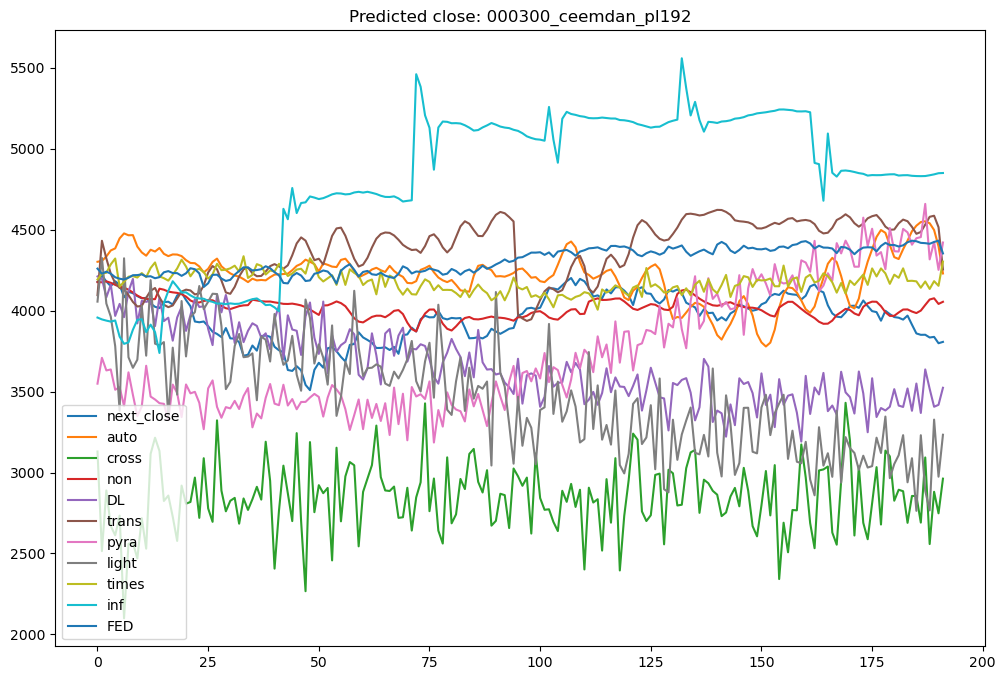

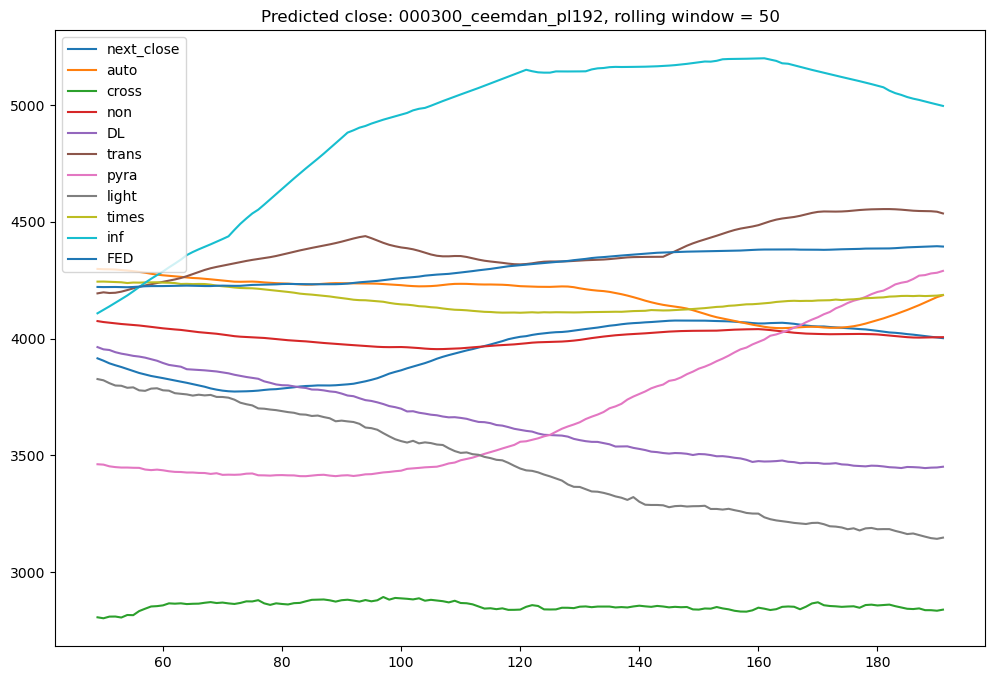

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df.next_close,label='next_close')
for model in models:
    plt.plot(df[model+'_pred_close'],label=model)
plt.legend()
plt.title('Predicted close: 000300_ceemdan_pl192')

plt.figure(figsize=(12,8))
plt.plot(df.next_close.rolling(50).mean(),label='next_close')
for model in models:
    plt.plot(df[model+'_pred_close'].rolling(50).mean(),label=model)
plt.legend()
plt.title('Predicted close: 000300_ceemdan_pl192, rolling window = 50')

In [ ]:
from scipy.stats import pearsonr
for model in models:
    print(model,':',pearsonr(df.next_close, df[model+'_pred_close']))

auto : (-0.15411043431333515, 0.032823214904922494)
cross : (-0.1292745279266959, 0.0739229845159063)
non : (0.2410475773601749, 0.0007570336418466727)
DL : (-0.26266251005880825, 0.00023265787788769702)
trans : (-0.10142934044247778, 0.1615488090819768)
pyra : (0.33753415848348195, 1.6868058114939834e-06)
light : (-0.26900940247725436, 0.00016132778742169104)
times : (-0.30768472042063727, 1.4160986884912492e-05)
inf : (0.20020747441165815, 0.005364549484729169)
FED : (0.4750803302772484, 3.3426441357986635e-12)


In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.cumprod(1+df.close),label='next_return')
for model in models:
    plt.plot(np.cumprod(1+df[model+'_pred_close']),label=model)
plt.legend()
plt.title('cumProb')

In [ ]:
df.rename(columns={'close':'next_return'})

,auto_high,auto_low,auto_trend,auto_pred_close,cross_high,cross_low,cross_trend,cross_pred_close,non_high,non_low,...,times_pred_close,inf_high,inf_low,inf_trend,inf_pred_close,FED_high,FED_low,FED_trend,FED_pred_close,next_return
0,0.000121,0.000121,0.000121,0.000363,-0.005048,-0.005048,-0.005048,-0.015143,0.003347,0.003347,...,0.005733,0.000196,0.000196,0.000196,0.000589,-0.003007,-0.003007,-0.003007,-0.009022,-0.010095
1,0.001037,0.001037,0.001037,0.003112,-0.006798,-0.006798,-0.006798,-0.020394,0.000927,0.000927,...,0.007207,0.000169,0.000169,0.000169,0.000508,-0.003338,-0.003338,-0.003338,-0.010014,-0.010248
2,0.001597,0.001597,0.001597,0.004792,-0.004782,-0.004782,-0.004782,-0.014346,0.000835,0.000835,...,0.003494,0.000340,0.000340,0.000340,0.001019,-0.002129,-0.002129,-0.002129,-0.006386,0.000859
3,0.000916,0.000916,0.000916,0.002748,-0.006947,-0.006947,-0.006947,-0.020842,0.000895,0.000895,...,0.007087,0.000548,0.000548,0.000548,0.001643,-0.001243,-0.001243,-0.001243,-0.003728,0.004495
4,0.000050,0.000050,0.000050,0.000151,-0.010212,-0.010212,-0.010212,-0.030635,0.000243,0.000243,...,-0.002507,0.000157,0.000157,0.000157,0.000470,-0.003090,-0.003090,-0.003090,-0.009271,-0.009552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,-0.003315,-0.003315,-0.003315,-0.009944,-0.003922,-0.003922,-0.003922,-0.011765,-0.000187,-0.000187,...,0.017167,0.000073,0.000073,0.000073,0.000219,0.000640,0.000640,0.000640,0.001920,-0.016389
397,-0.001934,-0.001934,-0.001934,-0.005803,-0.007980,-0.007980,-0.007980,-0.023940,-0.000050,-0.000050,...,-0.006676,0.000056,0.000056,0.000056,0.000167,0.000826,0.000826,0.000826,0.002477,0.007249
398,-0.001102,-0.001102,-0.001102,-0.003305,-0.003949,-0.003949,-0.003949,-0.011846,0.000125,0.000125,...,0.015727,0.000039,0.000039,0.000039,0.000118,0.000614,0.000614,0.000614,0.001841,-0.003835
399,-0.000565,-0.000565,-0.000565,-0.001694,-0.007752,-0.007752,-0.007752,-0.023256,0.000454,0.000454,...,0.009413,0.000041,0.000041,0.000041,0.000122,0.001648,0.001648,0.001648,0.004945,0.011719


In [ ]:
df.to_csv('./outputs/ceemdan_pl192_slide0.csv')

## For raw data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 提取RESULT文件里的模型名和预测数据
def read_result(file_name,first_):
    model_names,  names = ['auto', 'cross', 'non', 'DL', 'trans', 'pyra', 'times', 'inf', 'light', 'FED'], []
    preds, trues = [], []
    for num_of_model in range(10):
        files = os.listdir(f'/userhome/cs2/u3604482/capstone/Time-Series-Library-main/RESULTS/{file_name}/results') 
        lastIndex, curIndex, count, name = -1, -1, 0, files[num_of_model]
        preds.append(f'/userhome/cs2/u3604482/capstone/Time-Series-Library-main/RESULTS/{file_name}/results/{name}/pred.npy')
        trues.append(f'/userhome/cs2/u3604482/capstone/Time-Series-Library-main/RESULTS/{file_name}/results/{name}/true.npy')
        while count < first_+1:
            lastIndex = curIndex
            curIndex += name.index('_') + 1
            count += 1
            name = files[num_of_model][curIndex+1:]
        if (model_name := files[num_of_model][lastIndex+1:curIndex]) in model_names:
            names.append(model_name)
        else:
            print("WRONG:",model_name)
    return names, preds, trues

# 为每个模型建立预测数据的data frame
def create_pred_df(model, model_names, preds, trues, slide0):
    model_index = model_names.index(model)
    pred = np.load(preds[model_index]).squeeze()[:,:,-1] if slide0==False else np.load(preds[model_index]).squeeze()[:,-1]
    true = np.load(trues[model_index]).squeeze()[:,:,-1] if slide0==False else np.load(trues[model_index]).squeeze()[:,-1]
    preds, trues = {}, {}
    preds[model] = pred.tolist()
    trues[model] = true.tolist()
    preds = pd.DataFrame(preds)
    trues = pd.DataFrame(trues)
    return preds, trues
def concat(closeOrReturn, preds, trues, slide0):
    models = ['auto', 'cross', 'non', 'DL', 'trans', 'pyra', 'light', 'times', 'inf', 'FED']
    df = pd.DataFrame([])
    for model in models:
        df = pd.concat([df,create_pred_df(model, model_names, preds, trues, slide0)[0]], axis=1)
    df[closeOrReturn] = create_pred_df(model, model_names, preds, trues, slide0)[1]
    return df

In [ ]:
model_names, preds, trues = read_result('000300_pl96',5)
df = concat('next_close', preds, trues, 0)
df.to_csv('./outputs/000300_pl96.csv')
len(df.next_close[0])

96